# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [28]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from utils.detectConstantSegments import detectConstantSegments
from utils.computeSlotsAverage import computeSlotsAverage
from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load some data

   

In [ ]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
currentSlots = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + currentSlots


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


### Plot the data

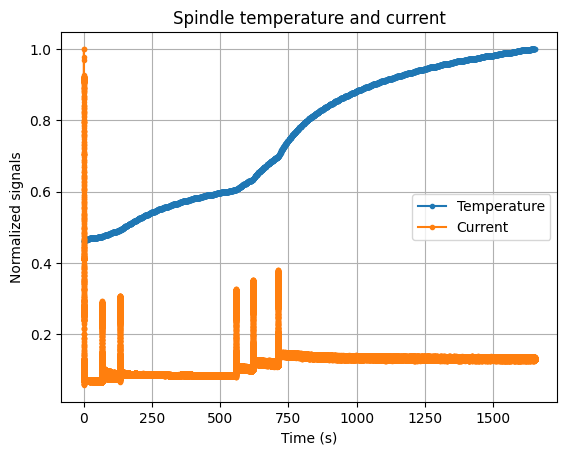

In [5]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

### Plot the data averaged by slots

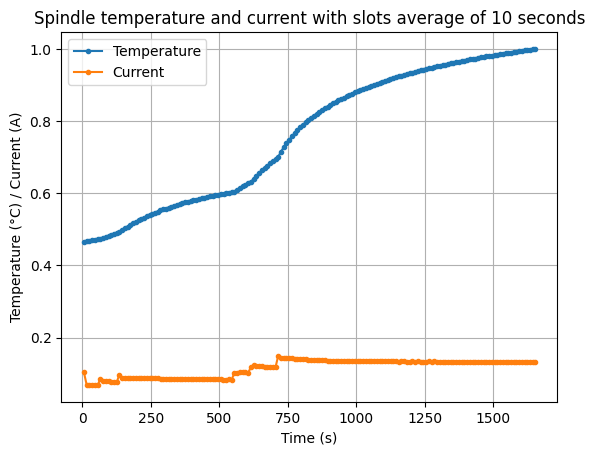

In [7]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Current (A)")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

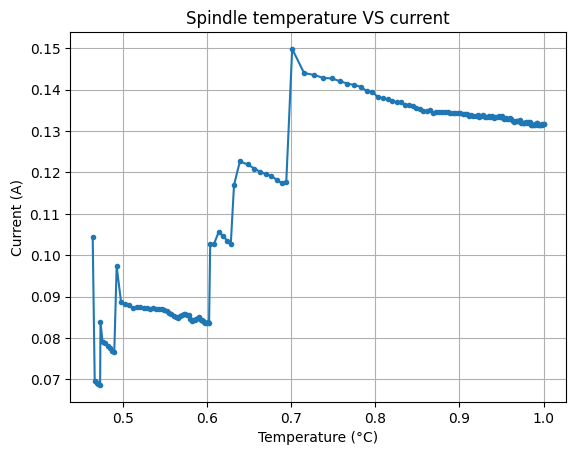

In [8]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Test `etTemperatureCorrectionData` on various samples

We want to plot the current VS temperature plot for multiple samples.

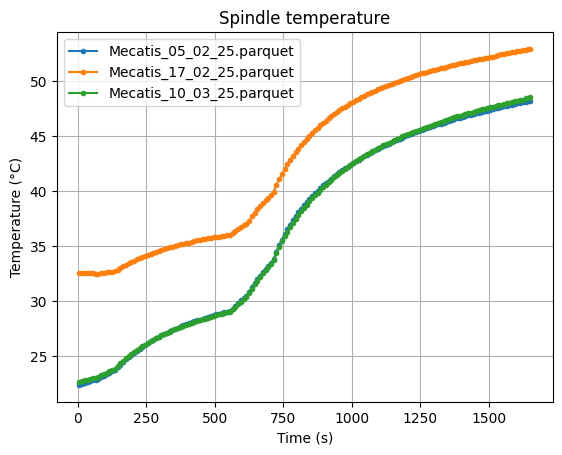

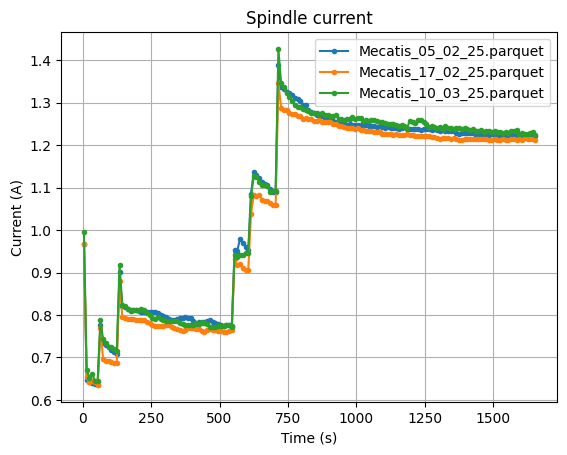

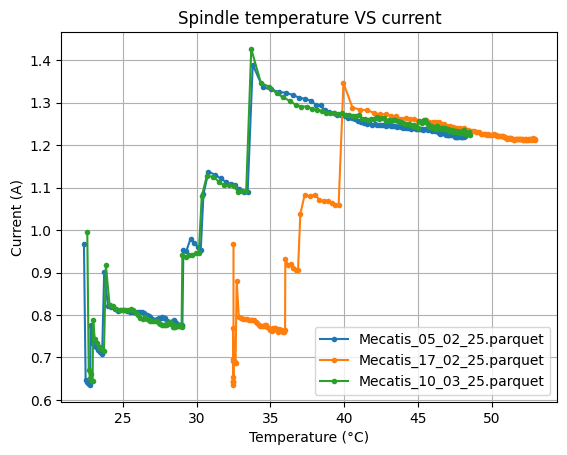

In [ ]:
dataPath: Path = "../../data/normalized-2025_04_08/"

samples: list[Path] = ["Mecatis_05_02_25.parquet", "Mecatis_17_02_25.parquet", "Mecatis_10_03_25.parquet"] 

rawData = []
for sample in samples:
    path = os.path.join(dataPath, sample)
    currentData = pd.read_parquet(path)
    rawData.append(getTemperatureCorrectionData(currentData))

showTempCorrectionPlots(rawData, samples)

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [ ]:


def errorFun(x: float, data: pd.Series, reference: pd.Series) -> float:
    error = ((data - x - reference)**2).sum()/len(data) # mean square error (MSE)
    return error

def findTemperatureOffset(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(errorFun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse

### Test the function on some data


In [ ]:
offset1, error1 = findTemperatureOffset(rawData[1]["temperature"], rawData[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(rawData[2]["temperature"], rawData[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  Mecatis_17_02_25.parquet
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  Mecatis_10_03_25.parquet
Offset:  0.04 °C
RMSE:  0.14 °C


### Plot the corrected data

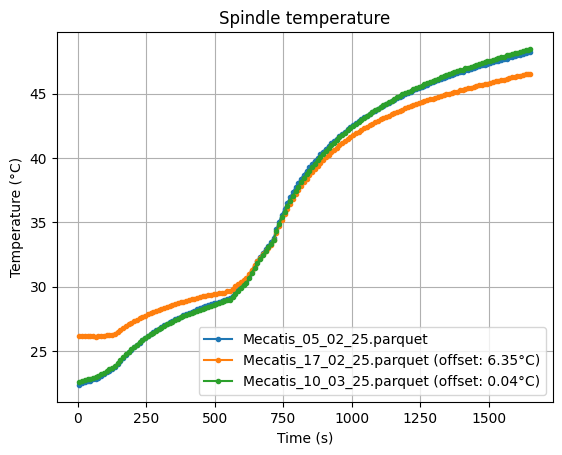

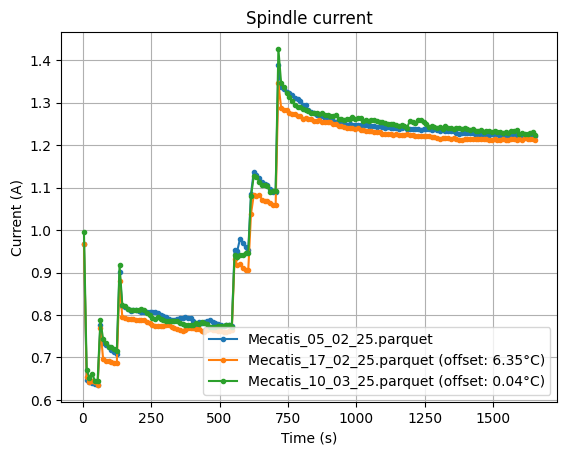

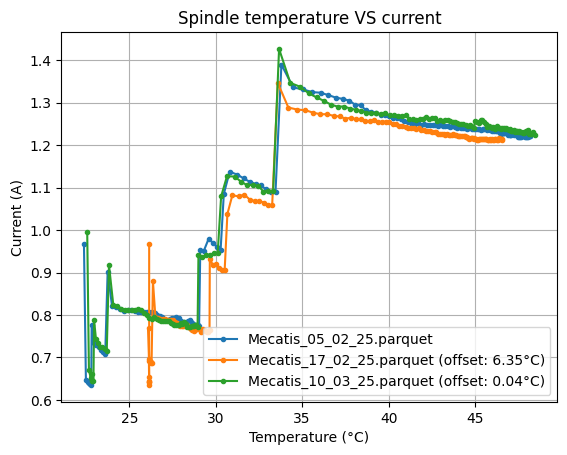

In [ ]:
rawData[1]["temperature"] = rawData[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

rawData[2]["temperature"] = rawData[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCorrectionPlots(rawData, samples)

## Check if segments are the same in all samples

In [6]:

dataPath: Path = "../../data/normalized-2025_04_08/"

def getSampleSegmentIndices(samplePath: Path) -> list:
    """
    Get the sample segment indices.

    Parameters
    ----------
    samplePath (str): The path to the sample.

    Returns
    -------
    list: Indices of the sample segments.
    """
    data = pd.read_parquet(samplePath)
    time = data["timeSeconds"]
    command = data["stSigSpindleVelocity"]
    return detectConstantSegments(time, command)

indices1 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_05_02_25.parquet"))
print("Indices 1: ", indices1)
indices2 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_17_02_25.parquet"))
print("Indices 2: ", indices2)
indices3 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_10_03_25.parquet"))
print("Indices 3: ", indices3)


Indices 1:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
Indices 2:  [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]
Indices 3:  [(892, 84083), (84958, 165521), (166396, 694796), (695672, 772690), (773566, 889276), (890151, 2065449)]


Remarks:
- different samples have different segment indices
- samples contains different numcer of points

## Split spindle current into segments
We want to split all the spindle current into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

First, load a sample and put useful signals into some variables.

In [19]:
dataPath: Path = "../../data/normalized-2025_04_08/"
samplePath = os.path.join(dataPath, "Mecatis_05_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]
segmentIndices = detectConstantSegments(time, command)
data = getTemperatureCorrectionData(rawData, timeSlot=None)


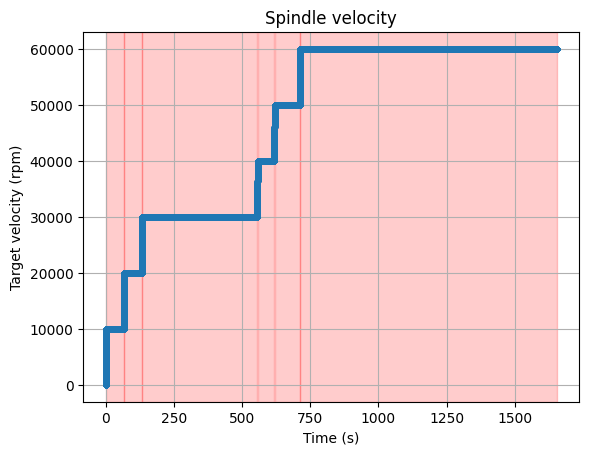

In [20]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

### Plot original spindle current

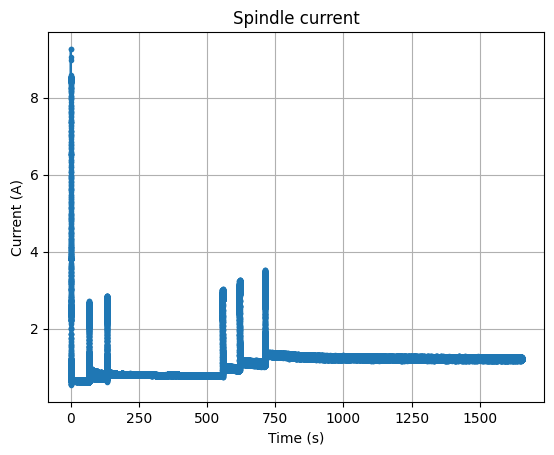

In [68]:
plt.figure()
plt.plot(time, data["current"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Spindle current")
plt.grid()
plt.show()

### Define functions

In [8]:
def splitSignal(data: pd.DataFrame, indices: list) -> list:
    """
    Split the data into segments.

    Parameters
    ----------
    signal (pd.DataFrame): The data, which can have any number of columns.
    indices (list): The indices of the segments.

    Returns
    -------
    list: The segments of the signal.
    """
    segments = []
    for segment in indices:
        segments.append(data.iloc[segment[0]:segment[1]])
    return segments

In [78]:
def plotSegments(segments: list, xSignal: str = "timeSeconds", ySignal: str = "current", nbPoints: int = None, title = "Spindle current", xlabel: str = "Time (s)", ylabel: str = "Current (A)" ) -> None:
    """
    Plot the segments of the signal.

    Parameters
    ----------
    segments (list[pd.DataFrame]): The segments of the signal. Each signal must only have 2 columns.
    title (str): The title of the plot.
    xlabel (str): The label of the x-axis.
    ylabel (str): The label of the y-axis.

    Returns
    -------
    None
    """

  

    nbSegments = len(segments)
    if nbSegments != 6:
        print("Warning: the number of segments is not 6. The plot may not be correct.")

    nbColumns = 2
    nbRows = 3

    plt.figure()
    fig, axs = plt.subplots(nbRows, nbColumns, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(title)

    for i in range(len(segmentIndices)):
        x = segments[i].loc[:, xSignal]
        y = segments[i].loc[:, ySignal]

        colIndex = i % nbColumns
        rowIndex = i // nbColumns

        pointsToPlot = len(x)
        if nbPoints != None:
            pointsToPlot = min(nbPoints, len(x))

        axs[rowIndex, colIndex].plot(x[:nbPoints], y[:nbPoints], "o-", markersize=3)
        axs[rowIndex, colIndex].set_xlabel(xlabel)
        axs[rowIndex, colIndex].set_ylabel(ylabel)
        axs[rowIndex, colIndex].set_title("Segment " + str(i+1) + " (" + str(pointsToPlot) + " points)")
        axs[rowIndex, colIndex].grid()

    plt.show()

### Test plotting raw segments

<Figure size 640x480 with 0 Axes>

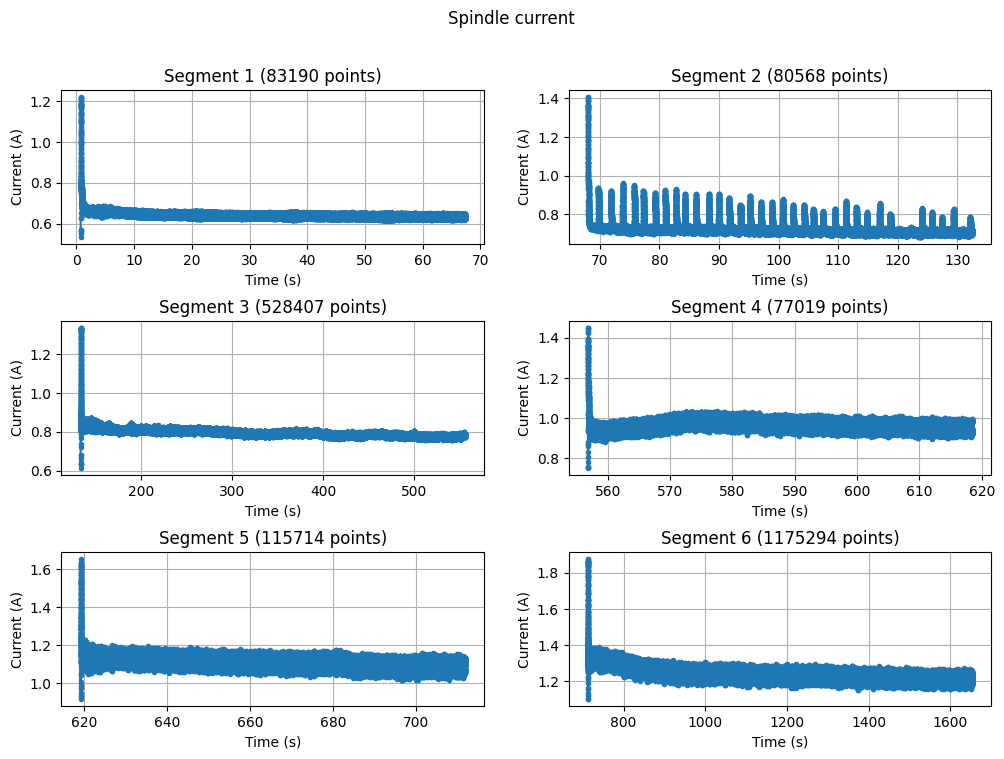

<Figure size 640x480 with 0 Axes>

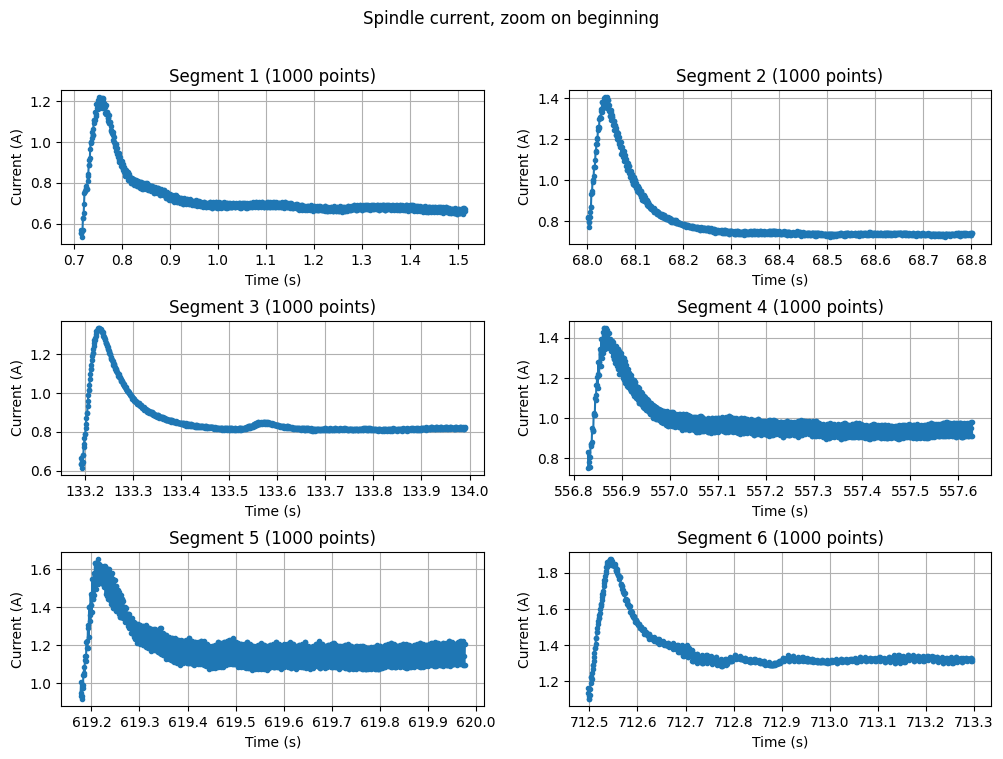

In [79]:
segments = splitSignal(data, segmentIndices)
plotSegments(segments)

# zoom in
plotSegments(segments, nbPoints=1000, title="Spindle current, zoom on beginning")

### Remove points at the beggining of segments

We want to remove the beginning of each segment in order to be in the stable state.

Frequency:  1250.0 Hz
Number of points to remove:  625


<Figure size 640x480 with 0 Axes>

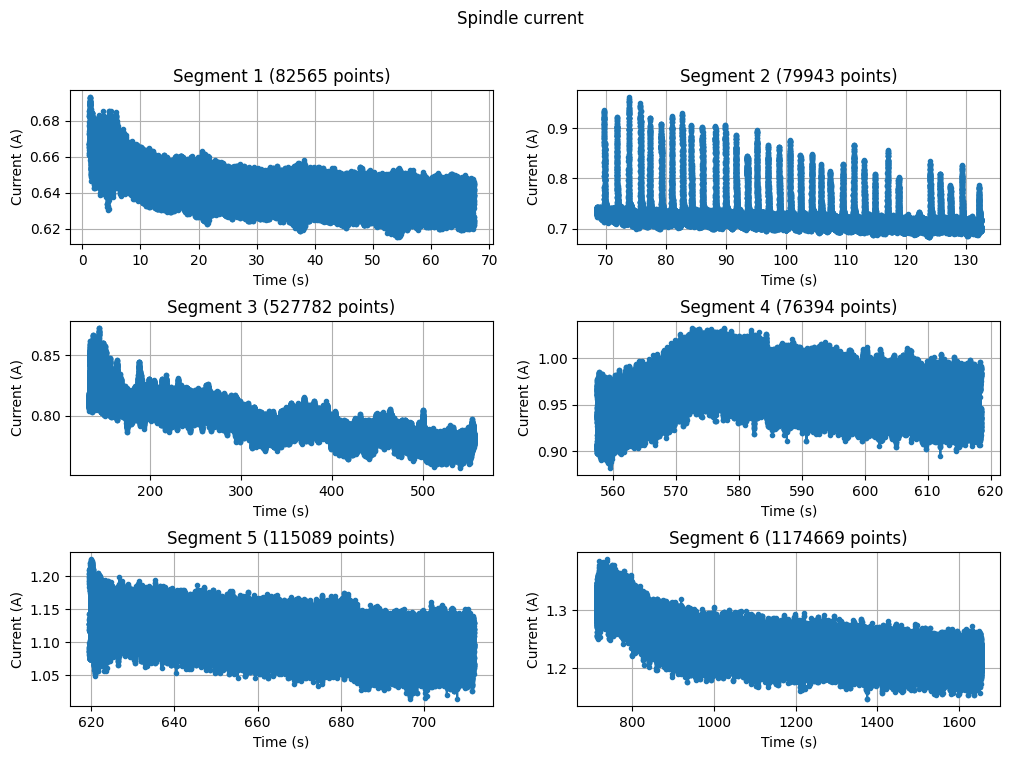

In [76]:
timeToRemove = 0.5 # seconds

frequency = 1 / (data.iloc[1, 0] - data.iloc[0,0]) # Hz
print("Frequency: ", frequency, "Hz")

nbPointsToRemove = int(timeToRemove * frequency) # number of points to remove
print("Number of points to remove: ", nbPointsToRemove)

cutSegments = []

for i in range(len(segments)):
    # remove the first nbPointsToRemove points
    cutSegments.append(segments[i].iloc[nbPointsToRemove:, :])

# plot the segments
plotSegments(cutSegments)


### Compute average by slots to reduce nb of points

<Figure size 640x480 with 0 Axes>

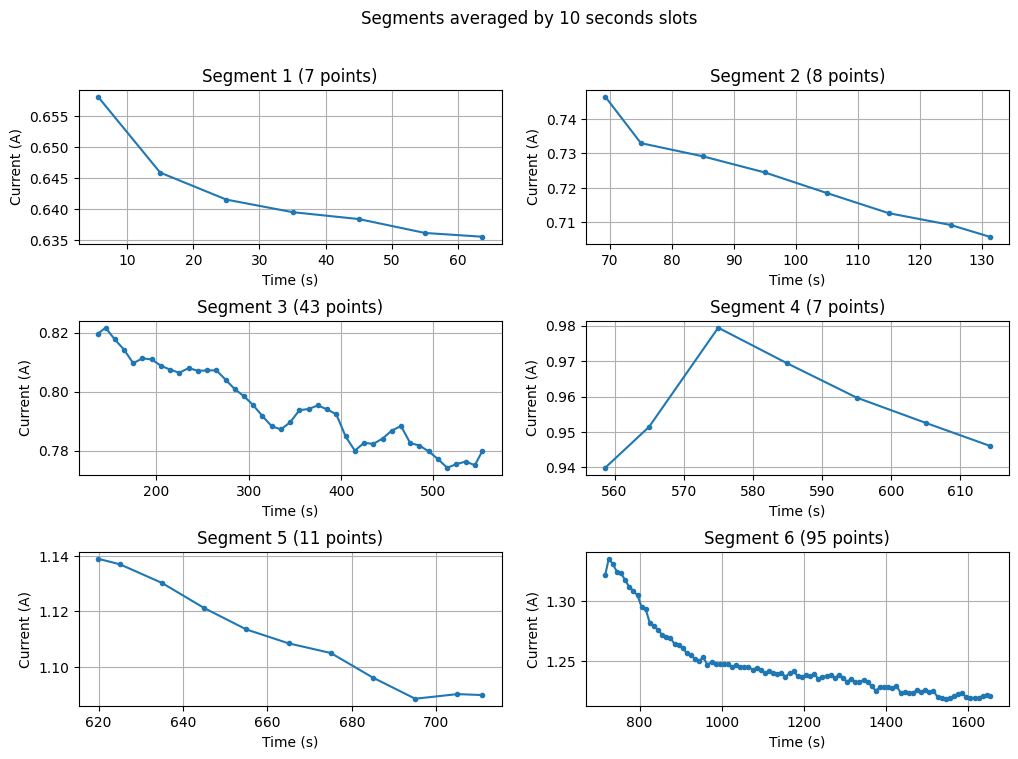

In [98]:
dt = 10 # seconds

averagedSegments = []

for i in range(len(cutSegments)):
    averagedSegments.append(computeSlotsAverage(cutSegments[i], dt))


# plot the segments
plotSegments(averagedSegments, title="Segments averaged by " + str(dt) + " seconds slots")

### Plot current versus temperature for each segment

<Figure size 640x480 with 0 Axes>

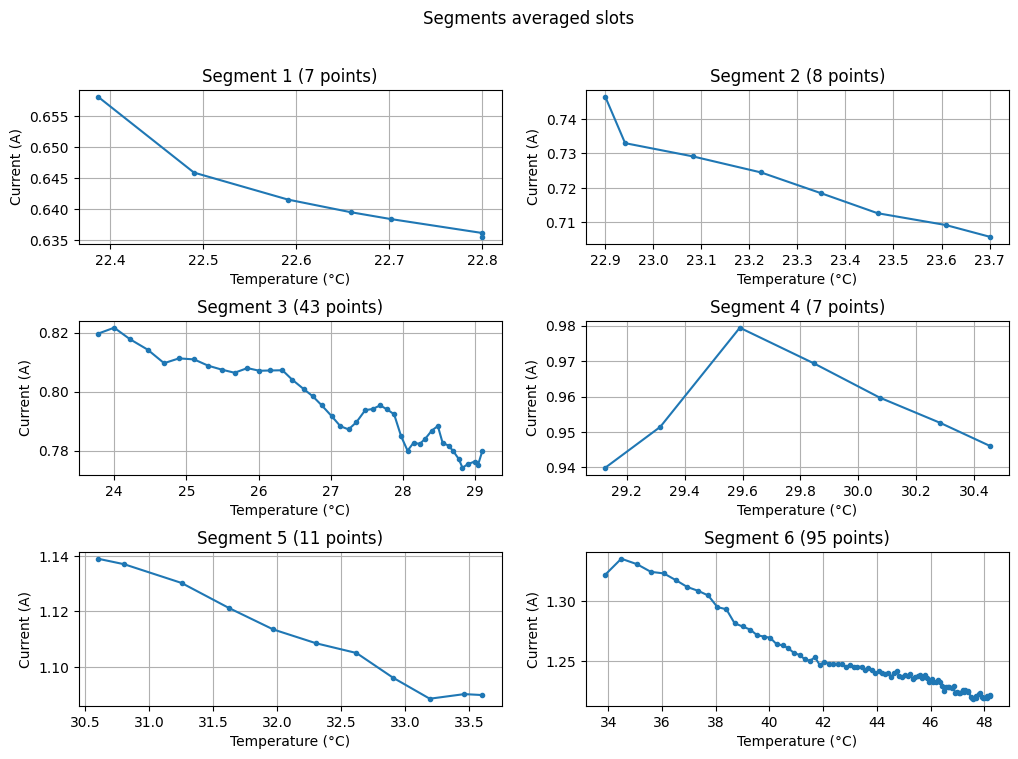

In [80]:
plotSegments(averagedSegments, xSignal= "temperature", ySignal="current", ylabel="Current (A)", xlabel="Temperature (°C)", title="Segments averaged slots")

## Compute regressions for each segment    

### Write functions

In [ ]:

def evalPolyReg(p: list, data: pd.DataFrame) -> pd.Series:
    """
    Evaluate a polynomial regression model.
    Parameters
    ----------
    p (list): The parameters of the model.
    data (pd.DataFrame): The data, which should have 2 columns.
    order (int): The order of the polynomial regression.
    """
    x = data.iloc[:, 0]

    result = p[0] # the first parameter is the offset
    for i in range(1, len(p)):
        result += p[i] * x**i
    return result

def errorFun(p: list, data: pd.DataFrame) -> float:
    """
    Function for a polynomial regression model.
    y = p[0] + p[1] * x + p[2] * x^2 + ... + p[n] * x^n
    Parameters
    ----------
    p (list): The parameters of the model.
    data (pd.DataFrame): The data, which should have 2 columns.
    """

    # check if the data has 2 columns
    if len(data.columns) != 2:
        raise ValueError("The data must have 2 columns.")
    
    model = evalPolyReg(p, data)
    error = ((data.iloc[:,1] - model)**2).sum()/len(data) # mean square error (MSE)
    return error

def getPolyRegression(data: pd.DataFrame, order = 1) -> list:
    x0 = [0.0] * (order + 1)
    result = minimize(errorFun, x0, args=(data))
    return result.x, np.sqrt(result.fun) # return the weights and the rmse

 ### Test the functions

Parameters:  [11.61581655 -1.89240596]
RMSE:  0.9463835893712311
Parameters:  [ 1.09073580e+01  7.79884604e-03 -8.75605617e-01  1.00557821e-01]
RMSE:  0.7727258118279647


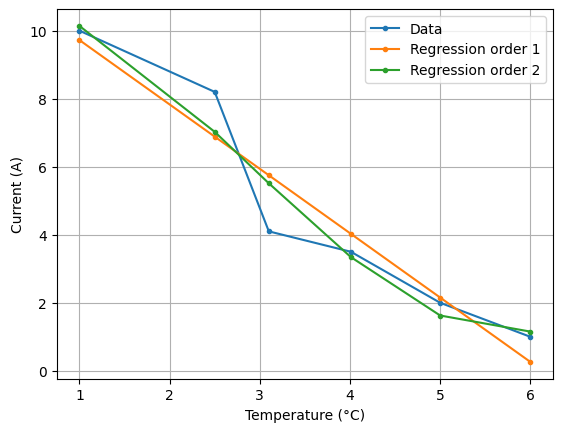

In [178]:
testData = pd.DataFrame()
testData["temperature"] = [1,2.5,3.1,4.01,5,6]
testData["current"] = [10, 8.2, 4.1, 3.5,2,1]

reg1, err1 = getPolyRegression(testData, order=1)
print("Parameters: ", reg1)
print("RMSE: ", err1)

model1 = evalPolyReg(reg1, testData)

reg2, err2 = getPolyRegression(testData, order=3)
print("Parameters: ", reg2)
print("RMSE: ", err2)

model2 = evalPolyReg(reg2, testData)

plt.figure()
plt.plot(testData["temperature"], testData["current"], "o-", markersize=3)
plt.plot(testData["temperature"], model1, "o-", markersize=3)
plt.plot(testData["temperature"], model2, "o-", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.legend(["Data", "Regression order 1", "Regression order 2"])
plt.grid()
plt.show()

### Compute regressions on real data

   temperature   current
0    22.387020  0.658175
1    22.490159  0.645879
2    22.591259  0.641502
3    22.658412  0.639467
4    22.701689  0.638348
5    22.799667  0.636095
6    22.800000  0.635486
Regression order 1:  [ 1.73283159 -0.04819135] , RMSE:  0.0025 A
Regression order 2:  [ 0.00938846  0.10806412 -0.00353929] , RMSE:  0.0026 A


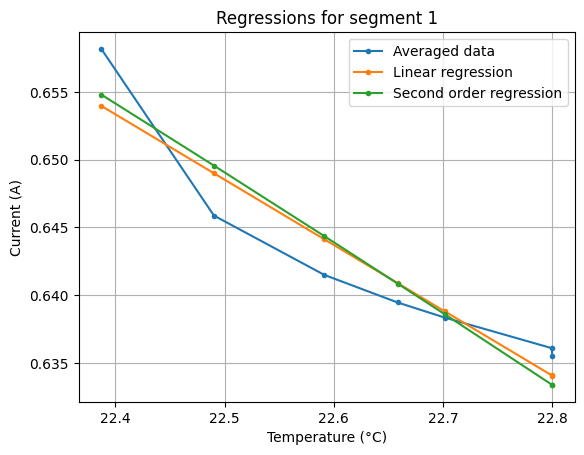

In [189]:
segment1 = averagedSegments[0]
signal = segment1.drop(columns=["timeSeconds"])
print(signal)

reg1, err1 = getPolyRegression(signal)
reg2, err2 = getPolyRegression(signal, order=2)

print("Regression order 1: ", reg1, ", RMSE: ", err1.round(4), "A")
print("Regression order 2: ", reg2, ", RMSE: ", err2.round(4), "A")

model1 = evalPolyReg(reg1, signal)
model2 = evalPolyReg(reg2, signal)

plt.figure()
plt.plot(signal.loc[:, "temperature"], signal.loc[:, "current"], "o-", markersize=3)
plt.plot(signal.loc[:, "temperature"], model1, "o-", markersize=3)
plt.plot(signal.loc[:, "temperature"], model2, "o-", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Regressions for segment 1")
plt.grid()
plt.legend(["Averaged data", "Linear regression", "Second order regression"])
plt.show()

### Subtract regression from the current data

We consider the variation of the current depending on the temperature as a bias. In order to remove it, we subtract the regression data from the current data.